# Analyzing the different statistical information leakage estimates (RQ1 and RQ2 (partially) in the paper)

This notebook generates the figures and tables comparing the different statistical information leakage estimates. The results correspond to the RQ1 and RQ2 (partially) in the paper.

## Parsing the estimates in `result/` directory

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import os

# Set the working directory to the root of the artifact directory.
# For example, if the current working directory is 
# where this notebook is ({root}/notebook/),
# the following line sets it to the root directory.
os.chdir("../")

output_domain_size_dict = {
    "smartgrid-1": (3, 12),
    "prob-termination-5": (6, 10),
    "prob-termination-7": (8, 10),
    "smartgrid-2": (9, 12),
    "prob-termination-9": (10, 10),
    "prob-termination-12": (13, 20),
    "reservoir-4": (16, 4),
    "window-20": (20, 20),
    "window-24": (24, 24),
    "smartgrid-3": (27, 12),
    "window-28": (28, 28),
    "window-32": (32, 32),
    "reservoir-6": (64, 8),
    "smartgrid-4": (81, 12),
    "smartgrid-5": (243, 12),
    "reservoir-8": (256, 16),
    "random-walk-3": (500, 24),
    "random-walk-5": (500, 31),
    "random-walk-7": (500, 33),
    "random-walk-14": (500, 40),
    "reservoir-10": (1024, 32),
    "reservoir-12": (4096, 64),
}
subject_name_map = {
    "smartgrid-1": "SG1",
    "smartgrid-2": "SG2",
    "prob-termination-5": "PT5",
    "prob-termination-7": "PT7",
    "prob-termination-9": "PT9",
    "prob-termination-12": "PT12",
    "smartgrid-3": "SG3",
    "reservoir-6": "RV6",
    "window-20": "WD20",
    "window-24": "WD24",
    "window-28": "WD28",
    "window-32": "WD32",
    "smartgrid-4": "SG4",
    "smartgrid-5": "SG5",
    "reservoir-8": "RV8",
    "random-walk-14": "RW14",
    "random-walk-3": "RW3",
    "random-walk-5": "RW5",
    "random-walk-7": "RW7",
    "reservoir-10": "RV10",
    "reservoir-4": "RV4",
    "reservoir-12": "RV12",
}

subject_order = [
    "PT5",
    "PT7",
    "PT9",
    "PT12",
    "RW3",
    "RW5",
    "RW7",
    "RW14",
    "RV4",
    "RV6",
    "RV8",
    "RV10",
    "RV12",
    "SG1",
    "SG2",
    "SG3",
    "SG4",
    "SG5",
    "WD20",
    "WD24",
    "WD28",
    "WD32",
]

method_order = [
    "empirical",
    "ChaoFON",
    "ChaoFRN",
    "ChaoION",
    "ChaoIRN",
    "miller",
    "ChaoFOM",
    "ChaoFRM",
    "ChaoIOM",
    "ChaoIRM",
    "HyLeak",
]

method_rename = {
    "empirical": "Empirical",
    "miller": "Miller",
    "HyLeak": "HyLeak",
    "ChaoFON": "ChaoFON",
    "ChaoFRN": "ChaoFRN",
    "ChaoION": "ChaoSON",
    "ChaoIRN": "ChaoSRN",
    "ChaoFOM": "ChaoFOM",
    "ChaoFRM": "ChaoFRM",
    "ChaoIOM": "ChaoSOM",
    "ChaoIRM": "ChaoSRM",
}
#Suppressing the tick labels warning
import warnings
warnings.filterwarnings(
    "ignore",
    message = ".*set_ticklabels/*",
    category = UserWarning
)

/home/knittingirl/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.DataFrame(
    columns=["subject", "GT", "ratio", "method", "MI", "SE", "o.e."]
)
#Added to enable changed behavior the first time this code runs.
first_run = True
for subject in output_domain_size_dict.keys():
    data_path = f"result/esti-merged-{subject}-i-xy.csv"
    if os.path.exists(data_path) == False:
        print(f"WARN: {data_path} not found")
    data = pd.read_csv(data_path)
    GT = data["GT"].values[0]
    data = data.drop(columns=["GT"])
    data_melt = data.melt(
        id_vars=["Nx", "trial"], var_name="method", value_name="MI"
    )
    # var order to method_order
    data_melt["method"] = pd.Categorical(data_melt["method"], method_order)
    # rename method
    data_melt["method"] = data_melt["method"].map(method_rename)
    data_melt["SE"] = (data_melt["MI"] - GT) ** 2
    data_mean = (
        data_melt.drop(columns=["SE"])
        .groupby(["Nx", "method"], observed=False)
        .mean()
        .reset_index()
        .drop(columns=["trial"])
    )
    data_mse = (
        data_melt.drop(columns=["MI"])
        .groupby(["Nx", "method"], observed=False)
        .mean()
        .reset_index()
        .drop(columns=["trial"])
    )
    data_mean = data_mean.merge(data_mse, on=["Nx", "method"])
    NS_x, NS_y = output_domain_size_dict[subject]
    data_mean["ratio"] = data_mean["Nx"] / NS_y
    data_mean.loc[data_mean["ratio"] < 1, "ratio"] = 0.5
    data_mean["subject"] = subject_name_map[subject]
    data_mean["GT"] = GT
    data_mean["o.e."] = data_mean["MI"] - GT > 0
    #Adding logic to avoid concatenation with an empty data structure.
    if first_run == True:
        df = data_mean.copy()
        first_run = False
    else:
        df = pd.concat([df, data_mean], ignore_index=True)
df = df.dropna(subset=["MI"])
df["bias"] = df["MI"] - df["GT"]
display(df)

,Nx,method,MI,SE,ratio,subject,GT,o.e.,bias
0,6,Empirical,0.394855,0.127088,0.5,SG1,0.065825,True,0.329030
1,6,ChaoFON,0.442915,0.161000,0.5,SG1,0.065825,True,0.377090
2,6,ChaoFRN,0.398220,0.130445,0.5,SG1,0.065825,True,0.332395
3,6,ChaoSON,0.340180,0.096639,0.5,SG1,0.065825,True,0.274355
4,6,ChaoSRN,0.308041,0.075884,0.5,SG1,0.065825,True,0.242216
...,...,...,...,...,...,...,...,...,...
963,320,ChaoFOM,1.774327,0.028717,5.0,RV12,1.604873,True,0.169454
964,320,ChaoFRM,1.776545,0.029474,5.0,RV12,1.604873,True,0.171672
965,320,ChaoSOM,1.625853,0.000441,5.0,RV12,1.604873,True,0.020980
966,320,ChaoSRM,1.625842,0.000441,5.0,RV12,1.604873,True,0.020969


## Mean bias and MSE comparison (Figure 4 and 5 in the paper)

The mean bias and MSE for each estimate are plotted as a boxplot.

<Axes: xlabel='Sample Ratio', ylabel='Mean Bias'>

<Axes: xlabel='Sample Ratio', ylabel='MSE'>

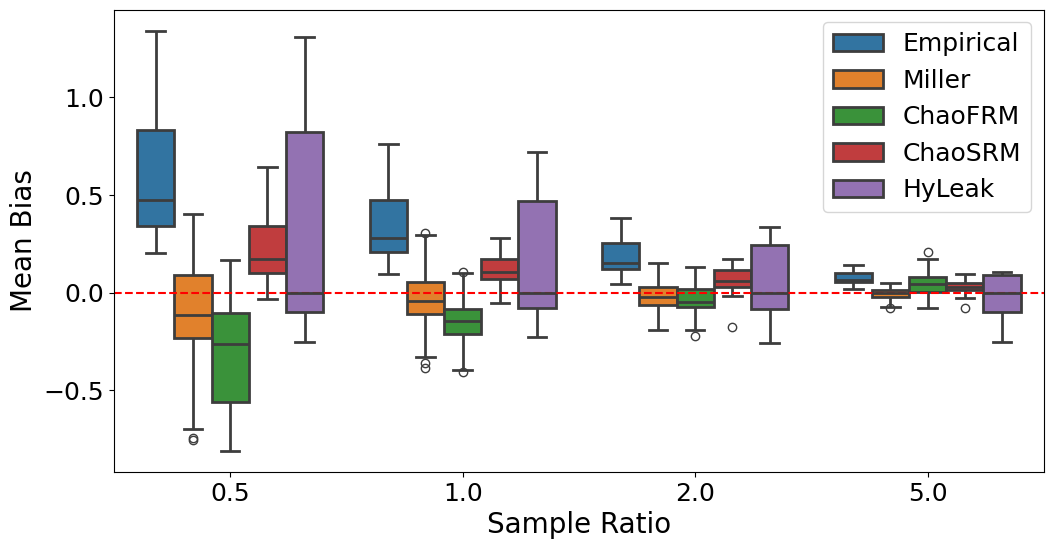

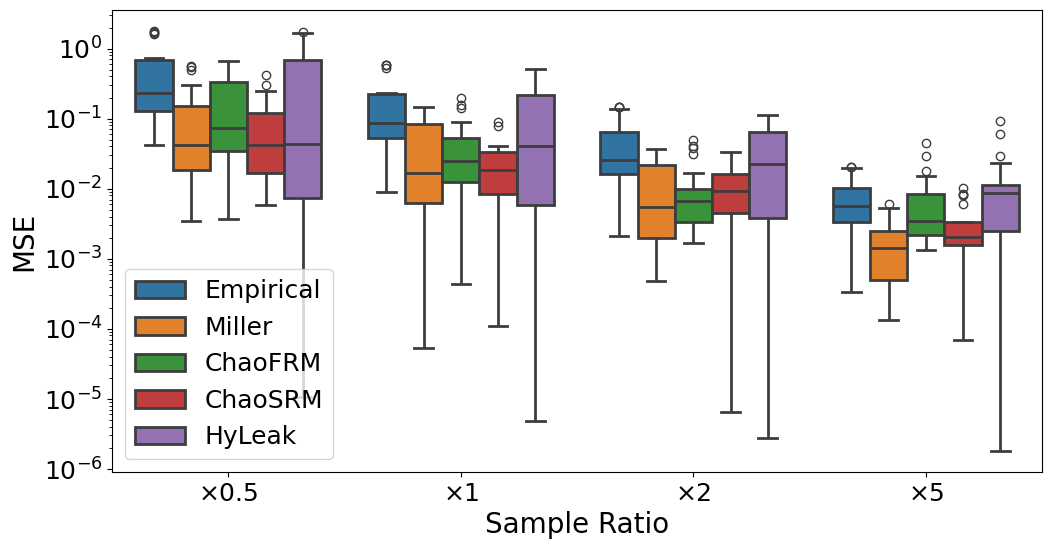

In [3]:
method_order = ["Empirical", "Miller", "ChaoFRM", "ChaoSRM", "HyLeak"]
df_temp = df.drop(columns=["GT", "MI"])
df_temp = df_temp.loc[df_temp["method"].isin(method_order)]
df_temp["method"] = pd.Categorical(df_temp["method"], method_order)

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    x="ratio",
    y="bias",
    hue="method",
    data=df_temp,
    ax=ax,
    linewidth=2,
)
ax.axhline(y=0, color="red", linestyle="--")
ax.set_xlabel(r"Sample Ratio", fontsize=20)

ax.tick_params(axis="x", labelsize=18)
ax.set_ylabel(r"Mean Bias", fontsize=20)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=18)
ax.legend(loc="upper right", ncol=1, fontsize=18)
display(ax)
fig.savefig("figures/rq1-result-bias.pdf", bbox_inches="tight")

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    x="ratio",
    y="SE",
    hue="method",
    data=df_temp,
    ax=ax,
    linewidth=2,
)
ax.set_xlabel(r"Sample Ratio", fontsize=20)
ax.set_xticklabels(
    [r"$\times$0.5", r"$\times$1", r"$\times$2", r"$\times$5"], fontsize=18
)
ax.set_ylabel(r"MSE", fontsize=20)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=18)
ax.legend(loc="lower left", ncol=1, fontsize=18)
ax.set_yscale("log")

display(ax)
# save
fig.savefig("figures/rq1-result-mse.pdf", bbox_inches="tight")

In [6]:
data = []

for subject in output_domain_size_dict.keys():
    # print(f"subject: {subject}")
    s_xy_path = os.path.join("data1M/", f"{subject}-s-xy.csv")
    s_xy = np.loadtxt(s_xy_path, delimiter=",", dtype=int)
    p_xy = s_xy / np.sum(s_xy)
    input_domain_size, output_domain_size = s_xy.shape
    num_zero_event = np.sum(s_xy == 0)
    num_samples_ratio = np.array([0.5, 1, 2, 5])
    num_samples = num_samples_ratio * output_domain_size * input_domain_size
    for idx, sample_size in enumerate(num_samples):
        num_rare_event = np.sum(p_xy < 1 / sample_size)
        Miller_oe = df.loc[
            (df["subject"] == subject_name_map[subject])
            & (df["ratio"] == num_samples_ratio[idx])
            & (df["method"] == "Miller"),
            "o.e.",
        ].values[0]
        ChaoSRM_oe = df.loc[
            (df["subject"] == subject_name_map[subject])
            & (df["ratio"] == num_samples_ratio[idx])
            & (df["method"] == "ChaoSRM"),
            "o.e.",
        ].values[0]
        data.append(
            [
                subject_name_map[subject],
                input_domain_size,
                output_domain_size,
                input_domain_size * output_domain_size,
                num_zero_event,
                num_zero_event / (input_domain_size * output_domain_size) * 100,
                num_samples_ratio[idx],
                sample_size,
                "Over" if Miller_oe else "Under",
                "Over" if ChaoSRM_oe else "Under",
            ]
        )
df2 = pd.DataFrame(
    data,
    columns=[
        "subject",
        "|X|",
        "|Y|",
        "|XY|",
        "p=0",
        "r(p=0)",
        "r(N)",
        "N",
        "Miller",
        "ChaoSRM",
    ],
)

subject_order = [
    "PT5",
    "PT7",
    "PT9",
    "PT12",
    "RW3",
    "RW5",
    "RW7",
    "RW14",
    "RV4",
    "RV6",
    "RV8",
    "RV10",
    "RV12",
    "SG1",
    "SG2",
    "SG3",
    "SG4",
    "SG5",
    "WD20",
    "WD24",
    "WD28",
    "WD32",
]
df2["subject"] = pd.Categorical(df2["subject"], subject_order)
df2 = df2.sort_values(by=["subject", "r(N)"])
df2

,subject,|X|,|Y|,|XY|,p=0,r(p=0),r(N),N,Miller,ChaoSRM
4,PT5,6,10,60,19,31.666667,0.5,30.0,Under,Over
5,PT5,6,10,60,19,31.666667,1.0,60.0,Under,Over
6,PT5,6,10,60,19,31.666667,2.0,120.0,Under,Over
7,PT5,6,10,60,19,31.666667,5.0,300.0,Under,Over
8,PT7,8,10,80,21,26.250000,0.5,40.0,Under,Over
...,...,...,...,...,...,...,...,...,...,...
43,WD28,28,28,784,0,0.000000,5.0,3920.0,Over,Over
44,WD32,32,32,1024,0,0.000000,0.5,512.0,Over,Over
45,WD32,32,32,1024,0,0.000000,1.0,1024.0,Over,Over
46,WD32,32,32,1024,0,0.000000,2.0,2048.0,Over,Over


## Correlation between the estimator safety vs. proportion of undetectable events (RQ1)

The correlation between the estimator safety and the proportion of undetectable events is calculated and plotted.

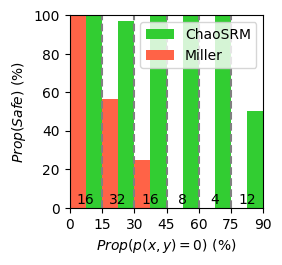

In [7]:
rp0_data = []
bins = [0, 15, 30, 45, 60, 75, 90]
num_configs = []
# histogram
for bin_idx in range(len(bins) - 1):
    rang = [bins[bin_idx], bins[bin_idx + 1]]
    miller_oep = (
        df2[
            (df2["r(p=0)"] >= rang[0])
            & (df2["r(p=0)"] < rang[1])
            & (df2["Miller"] == "Over")
        ].shape[0]
        / df2[(df2["r(p=0)"] >= rang[0]) & (df2["r(p=0)"] < rang[1])].shape[0]
        * 100
    )
    chaosrm_oep = (
        df2[
            (df2["r(p=0)"] >= rang[0])
            & (df2["r(p=0)"] < rang[1])
            & (df2["ChaoSRM"] == "Over")
        ].shape[0]
        / df2[(df2["r(p=0)"] >= rang[0]) & (df2["r(p=0)"] < rang[1])].shape[0]
        * 100
    )
    num_config = df2[
        (df2["r(p=0)"] >= rang[0]) & (df2["r(p=0)"] < rang[1])
    ].shape[0]
    rp0_data.append([rang[0], rang[1], miller_oep, chaosrm_oep])
    num_configs.append(num_config)
rp0_df = pd.DataFrame(rp0_data, columns=["min", "max", "Miller", "ChaoSRM"])
rp0_df["mid"] = (rp0_df["min"] + rp0_df["max"]) / 2
fig, ax = plt.subplots(figsize=(2.5, 2.5))
plt.bar(
    [v + 3.75 for v in rp0_df["mid"].values],
    rp0_df["ChaoSRM"].values,
    color="limegreen",
    label="ChaoSRM",
    width=7.5,
)
plt.bar(
    [v - 3.75 for v in rp0_df["mid"].values],
    rp0_df["Miller"].values,
    color="tomato",
    label="Miller",
    width=7.5,
)
# legend
ax.legend(loc="upper right", ncol=1, fontsize=10)
# x ticks
ax.set_xticks(bins)
ax.set_ylim([0, 100])
ax.set_xlim([min(rp0_df["min"].values), max(rp0_df["max"].values)])
ax.set_xlabel(r"$Prop(p(x,y)=0)$ (%)")
ax.set_ylabel(r"$Prop(Safe)$ (%)")
# print num_config above the x axis
for bin_idx in range(len(bins) - 1):
    ax.text(
        x=(bins[bin_idx] + bins[bin_idx + 1]) / 2,
        y=0.5,
        s=f"{num_configs[bin_idx]}",
        horizontalalignment="center",
        verticalalignment="bottom",
        fontsize=10,
    )
# vertical dashed line for bins
for bin_idx in range(len(bins) - 1):
    ax.axvline(x=bins[bin_idx], color="grey", linestyle="--")
fig.savefig("figures/miller-oe-rp0.pdf", bbox_inches="tight")

## Statistical tests for RQ1

The Wilcoxon signed-rank test is performed to compare the mean squared error of the different estimates.

In [8]:
from scipy import stats


def sttest(method1, method2, ratio=None):
    df_temp = df.loc[df["ratio"] == ratio] if ratio else df
    mse_m1 = df_temp[df_temp["method"] == method1]["SE"].values
    mse_m2 = df_temp[df_temp["method"] == method2]["SE"].values
    stat, p = stats.wilcoxon(mse_m1, mse_m2, alternative="greater")
    print(
        f"({len(mse_m1)}) method1: {method1} ({np.mean(mse_m1):.4f}), method2: {method2} ({np.mean(mse_m2):.4f}), ratio: {ratio}, p: {p:.4f}"
    )


for ratio in [0.5, 1, 2, 5]:
    for m1, m2 in [
        ("Empirical", "Miller"),
        ("Empirical", "ChaoFRM"),
        ("Empirical", "ChaoSRM"),
        ("Empirical", "HyLeak"),
        ("Miller", "ChaoFRM"),
        ("Miller", "ChaoSRM"),
        ("Miller", "HyLeak"),
        ("ChaoFRM", "ChaoSRM"),
        ("ChaoFRM", "HyLeak"),
        ("ChaoSRM", "HyLeak"),
    ]:
        sttest(m1, m2, ratio)

(22) method1: Empirical (0.5415), method2: Miller (0.1315), ratio: 0.5, p: 0.0042
(22) method1: Empirical (0.5415), method2: ChaoFRM (0.1870), ratio: 0.5, p: 0.0138
(22) method1: Empirical (0.5415), method2: ChaoSRM (0.0902), ratio: 0.5, p: 0.0000
(22) method1: Empirical (0.5415), method2: HyLeak (0.4450), ratio: 0.5, p: 0.0000
(22) method1: Miller (0.1315), method2: ChaoFRM (0.1870), ratio: 0.5, p: 0.9009
(22) method1: Miller (0.1315), method2: ChaoSRM (0.0902), ratio: 0.5, p: 0.5881
(22) method1: Miller (0.1315), method2: HyLeak (0.4450), ratio: 0.5, p: 0.9508
(22) method1: ChaoFRM (0.1870), method2: ChaoSRM (0.0902), ratio: 0.5, p: 0.2940
(22) method1: ChaoFRM (0.1870), method2: HyLeak (0.4450), ratio: 0.5, p: 0.8826
(22) method1: ChaoSRM (0.0902), method2: HyLeak (0.4450), ratio: 0.5, p: 0.9508
(22) method1: Empirical (0.1788), method2: Miller (0.0427), ratio: 1, p: 0.0026
(22) method1: Empirical (0.1788), method2: ChaoFRM (0.0465), ratio: 1, p: 0.0014
(22) method1: Empirical (0.17

## Statistical tests for RQ2

The Wilcoxon signed-rank test is performed to compare the mean squared error of the different configurations of our unseen event-aware estimator. We named the eight variants of our estimator as the following scheme: 
- ‘Chao’ 
- \+ ‘F’ (for the FL approach) or ‘S’ (for the BS approach) 
- \+ ‘O’ (for the original MD estimates) or ‘R’ (for the refined MD estimates) 
- \+ ‘N’ (for no bias correction) or ‘M’ (for Miller’s bias correction).


In [9]:
sttest("Empirical", "ChaoFON")
sttest("Empirical", "ChaoFRN")
sttest("Empirical", "ChaoSON")
sttest("Empirical", "ChaoSRN")

(88) method1: Empirical (0.1941), method2: ChaoFON (0.0462), ratio: None, p: 0.0001
(88) method1: Empirical (0.1941), method2: ChaoFRN (0.0393), ratio: None, p: 0.0000
(88) method1: Empirical (0.1941), method2: ChaoSON (0.0636), ratio: None, p: 0.0000
(88) method1: Empirical (0.1941), method2: ChaoSRN (0.0514), ratio: None, p: 0.0000


In [10]:
sttest("ChaoFON", "ChaoSON")
sttest("ChaoFRN", "ChaoSRN")
print()
sttest("ChaoFON", "ChaoFRN")
sttest("ChaoSON", "ChaoSRN")

(88) method1: ChaoFON (0.0462), method2: ChaoSON (0.0636), ratio: None, p: 0.4801
(88) method1: ChaoFRN (0.0393), method2: ChaoSRN (0.0514), ratio: None, p: 0.4701

(88) method1: ChaoFON (0.0462), method2: ChaoFRN (0.0393), ratio: None, p: 0.0000
(88) method1: ChaoSON (0.0636), method2: ChaoSRN (0.0514), ratio: None, p: 0.0000


In [11]:
sttest("Empirical", "Miller")
sttest("ChaoFRN", "ChaoFRM")
sttest("ChaoSRN", "ChaoSRM")

(88) method1: Empirical (0.1941), method2: Miller (0.0469), ratio: None, p: 0.0000
(88) method1: ChaoFRN (0.0393), method2: ChaoFRM (0.0634), ratio: None, p: 0.3073
(88) method1: ChaoSRN (0.0514), method2: ChaoSRM (0.0324), ratio: None, p: 0.0000
